In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import tensorflow as tf
from skimage import io, color, transform
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, top_k_accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from PIL import Image
from preprocessing import *
from machine_learning import *
import cv2 as cv

### Load data

Spiegare antialiasing e resize.

In [4]:
# Specify the base folder where all your image classes are stored
folder = 'data'

In [ ]:
start_data = datasets.ImageFolder(folder, transform=transforms.ToTensor())

### Check min and max height and width of the images.

In [8]:
check_max_min_dimensions(start_data)

Min Width: 71, Max Width: 6283
Min Height: 51, Max Height: 7786


### Since not all images have the same dimensions, we have to resize them to a standard dimension. We choose to resize images to (256, 256).

In [3]:
transformations = transforms.Compose([transforms.Resize((256, 256), antialias=True), transforms.ToTensor()])
data = datasets.ImageFolder(root = folder, transform=transformations)

In [10]:
class_map = {k:v for k,v in enumerate(data.classes)}
print(class_map)

{0: 'battery', 1: 'biological', 2: 'cardboard', 3: 'clothes', 4: 'glass', 5: 'metal', 6: 'paper', 7: 'plastic', 8: 'shoes', 9: 'trash'}


### Check if all images have the same dimensions and the same number of channels.

2.20 minuti per runnare.

In [10]:
check_dimensions(data)
check_channels(data)

All images have the same shape: torch.Size([256, 256]).
All images have 3 channels.


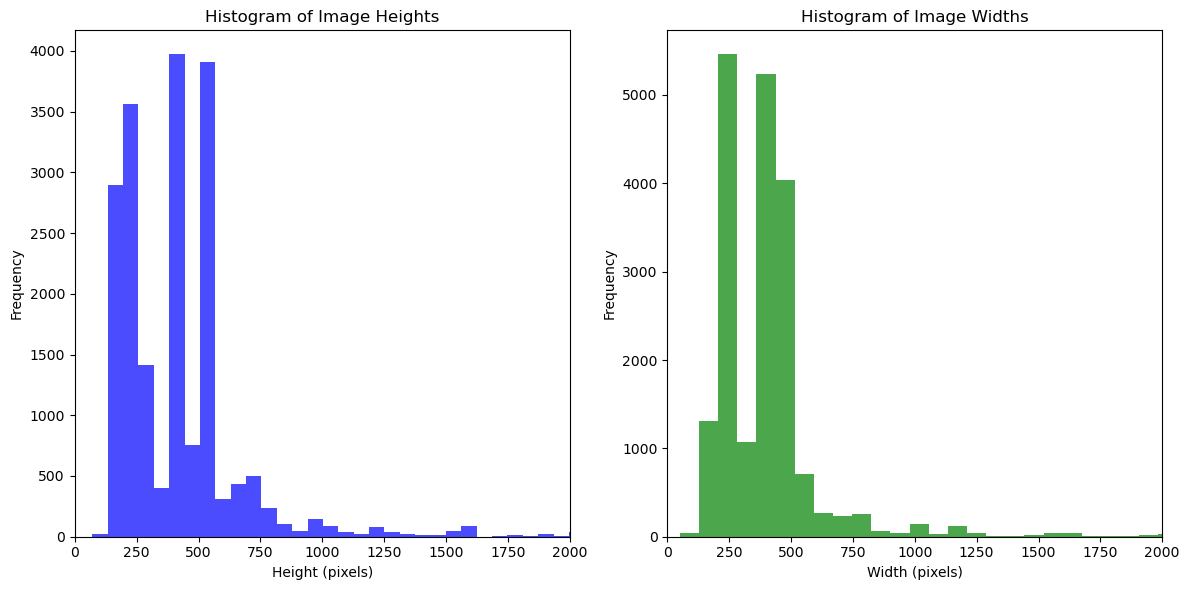

In [4]:
plot_image_size_histograms(data, bins=100)

### Check number of samples in each class.

In [11]:
count_images_per_class(data)

Class battery: 944 images
Class biological: 983 images
Class cardboard: 1810 images
Class clothes: 5323 images
Class glass: 3039 images
Class metal: 994 images
Class paper: 1650 images
Class plastic: 1915 images
Class shoes: 1977 images
Class trash: 772 images


### Data augmentation to bring all the classes to at least 1500 samples.

In [ ]:
input_dir = "data"  # Dataset originale diviso per classi
output_dir = "augmented_data"  # Dataset bilanciato
target_size = 1500  # Numero minimo desiderato di immagini per 

# Creare la cartella di output
os.makedirs(output_dir, exist_ok=True)

# Trasformazioni per data augmentation
augmentations = transforms.Compose([
    transforms.RandomRotation(20),  # Rotazione casuale fino a 20°
    transforms.RandomHorizontalFlip(p=0.5),  # Ribaltamento orizzontale
    transforms.RandomVerticalFlip(p=0.2),  # Ribaltamento verticale
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),  # Crop casuale con ridimensionamento
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Cambiamenti di colore
])


for class_name in os.listdir(input_dir):
    input_class_dir = os.path.join(input_dir, class_name)

    # Contare il numero di immagini nella classe
    num_images = len([img for img in os.listdir(input_class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))])

    if num_images < target_size:
        # Aumentare il numero di immagini con data augmentation
        augment_images(class_name, input_class_dir, num_images, target_size, augmentations=augmentations)
    else:
        print(f"Class {class_name} already has {num_images} images, no augmentation needed.")

print("Data augmentation completed.")

Augmenting 556 images for class: battery
Augmenting 517 images for class: biological
Class cardboard already has 1810 images, no augmentation needed.
Class clothes already has 5323 images, no augmentation needed.
Class glass already has 3039 images, no augmentation needed.
Augmenting 506 images for class: metal
Class paper already has 1650 images, no augmentation needed.
Class plastic already has 1915 images, no augmentation needed.
Class shoes already has 1977 images, no augmentation needed.
Augmenting 728 images for class: trash
Data augmentation completed.


In [7]:
data = datasets.ImageFolder(folder, transform=transformations)

In [18]:
len(data)

21714

### Save the dataset for the deep learning part

In [ ]:
torch.save(data, 'dataset.pt')

### Load images in the right format for scikit-learn.

In [ ]:
images, labels, class_names = load_images(folder)
images = images.astype(np.float32)

### Preprocessing the images

In [50]:
# Image normalization
images /= 255.0

### Remove noise from images using Gaussian Blur.

In [51]:
for i in range(len(images)):
    images[i] = cv.GaussianBlur(images[i], (5, 5), 0)

In [56]:
hists = [compute_histogram(images[i]) for i in range(len(images))]

### Flatten images

In [57]:
images = images.reshape(len(images), -1)

### Train Test Split.

In [58]:
x_train, x_test, y_train, y_test = train_test_split(hists, labels, test_size=0.2, random_state=42)

### SVM

In [75]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1, gamma='scale')  # Usa kernel RBF per catturare relazioni non lineari
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)


### K-NN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=100, weights='distance')

knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=100)

### RANDOM FOREST

In [79]:
from sklearn.ensemble import RandomForestClassifier
rnd = RandomForestClassifier(n_estimators=100, random_state=42)
rnd.fit(x_train, y_train)
y_pred = rnd.predict(x_test)


### Training error

In [81]:
y_pred_train = rnd.predict(x_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.96      0.54      0.69      1229
           1       0.91      0.11      0.20      1209
           2       0.91      0.31      0.46      1421
           3       0.31      0.99      0.47      4253
           4       0.91      0.26      0.41      2402
           5       0.93      0.22      0.35      1210
           6       0.83      0.07      0.13      1317
           7       0.90      0.17      0.28      1526
           8       0.97      0.35      0.52      1581
           9       0.98      0.35      0.52      1223

    accuracy                           0.44     17371
   macro avg       0.86      0.34      0.40     17371
weighted avg       0.77      0.44      0.41     17371



### Test error

In [82]:
y_pred = rnd.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.14      0.17       271
           1       0.10      0.01      0.02       291
           2       0.15      0.04      0.07       389
           3       0.30      0.97      0.46      1070
           4       0.17      0.04      0.07       637
           5       0.11      0.03      0.05       290
           6       0.10      0.01      0.02       333
           7       0.05      0.01      0.01       389
           8       0.18      0.07      0.10       396
           9       0.19      0.07      0.10       277

    accuracy                           0.27      4343
   macro avg       0.16      0.14      0.11      4343
weighted avg       0.18      0.27      0.16      4343



### Train, validation, test set split

In [5]:
len(data)

21714

In [6]:
images = []
labels = []

for image, label in data:
    images.append(image.numpy().flatten())  # Flatten the image into a 1D array
    labels.append(label)

# Convert lists to NumPy arrays
x = np.array(images)
y = np.array(labels)

print(x.shape, y.shape)


(21714, 196608) (21714,)


In [6]:
train_size = int(0.7*len(data))
test_size = int(0.2*len(data))
val_size = len(data)-train_size-test_size

torch.manual_seed(42)
train_dataset, temp_dataset = random_split(data, [train_size, len(data) - train_size],)
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [5]:
print(f'Train set length: {len(train_dataset)}.')
print(f'Validation set length: {len(val_dataset)}.')
print(f'Test set length: {len(test_dataset)}.')

Train set length: 15199.
Validation set length: 2173.
Test set length: 4342.


In [ ]:
x_train, y_train = split_set(train_dataset)
x_test, y_test = split_set(ConcatDataset([val_dataset, train_dataset]))

In [31]:
x_train.shape

torch.Size([15199, 3, 256, 256])

### K-Nearest-Neighbors

In [ ]:
knn = KNeighborsClassifier()
grid_knn = {'n_neighbors':[i for i in range(5, 355, 50)],
            'weights':['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski'],
            'p': [1, 2]}

grid = GridSearchCV(knn, grid_knn, cv=5, scoring='accuracy')
if grid is not None:
    grid.fit(x_train, y_train)

    print(f'Best score: {grid.best_score_}')
    for hp, value in grid.best_params_.items():
        print(f'{hp}:{value}\n')

ValueError: Found input variables with inconsistent numbers of samples: [15198, 15199]

### Compute histograms for each image.

In [ ]:
train_hists = np.array([])
for img, label in train_dataset:
    hist = compute_histogram(img)
    train_hists = np.append(train_hists, (hist, label))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.